# Computer Vision

## Introduction

In US alone, around 7500 yearly cases of mushrooms poisoning are reported [SOURCE](https://www.tandfonline.com/doi/full/10.1080/00275514.2018.1479561). According to the source, "misidentification of edible mushroom species appears to be the most common cause and may be preventable through education". To avoid expenses for hospitalization and in some cases pointless deaths, I have been hired by US National Health Service to create a machine learning model, that can recognize mushroom types. They want to install this on hand-held devices and to help people make the right choice when mushroom picking.

Objectives of this project
<ul>
    <li>Build Data Pipeline</li>
    <li>Preprocess Data</li>
    <li>Build Deep Neural Network</li>
    <li>Evaluate Performance</li>
</ul>

The aim of the Project
Build DNN model which help to identify Edible and Lethal poisonous mushrooms using transfer learning. This project will include data preprocessing, data analysis, model building steps.

The main dataset can be downloaded from [Kaggle](https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images)


## Notebook Preparation

In [1]:
# Standard library
import os
import random
import time
import glob
import warnings

# Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and Torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

# Machine Learning and Utilities
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm

# Custom utilities
from utils.plot_utils import (
    class_distribution_barplot,
    horizontal_hist_box_plot,
    plot_regplot,
    plot_learning_curve,
    cm_matrix,
    visualize_predictions,
)
from utils.utils import (
    move_bad_images,
    analyze_dataset,
    split_data,
    preprocess_images,
    count_files_in_split,
    clean_dataset,
    evaluate_model
)


In [2]:
# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
# Define datasets paths
data_path = "data/Mushrooms"
corrupted_images_path = "data/bad"
model_path = "./models"
checkpoints_dir = f"{model_path}/checkpoints"

In [4]:
# Notebook styles
sns.set(style="darkgrid", palette="pastel")
plt.rcParams["figure.figsize"] = [14, 6]

# Suppress warnings
warnings.filterwarnings("ignore")

In [5]:
# Check if CUDA is available
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using device: {DEVICE}")
    if "RTX" in torch.cuda.get_device_name(0):
        torch.set_float32_matmul_precision('medium')
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using device: cuda


## Data Cleaning

Check if all images are valid base by image type, image size and pixel information it contains.

In [6]:
%%time
# Run the cleaning
invalid_files, size_issues, black_or_white_images = clean_dataset(data_path)

Scanning folders: 9it [00:29,  3.27s/it]

CPU times: total: 29.3 s
Wall time: 29.4 s


In [7]:
# Report results
print(f"File is not an image format: {len(invalid_files)}")
print(f"Files with size issues (<1kb): {len(size_issues)}")
print(f"Black/white images: {len(black_or_white_images)}")

File is not an image format: 0
Files with size issues (<1kb): 0
Black/white images: 3


Some of the files will be excluded as those files are corrupted and will not be useful for our model and analysis.

In [8]:
# Images found out to be corrupted moved to separate folder
move_bad_images(black_or_white_images, corrupted_images_path, data_path)

Moved data\Mushrooms\Boletus\0051_rBIC-Uy9KzI.jpg to data\bad\Boletus.
Moved data\Mushrooms\Boletus\0105_7lVm0lLO6FQ.jpg to data\bad\Boletus.
Moved data\Mushrooms\Russula\092_43B354vYxm8.jpg to data\bad\Russula.
Moved 3 bad images to data/bad.


## Exploratory Data Analysis

Analyze our dataset to get more information about the data we have. 

In [9]:
# Analyze the dataset
class_distribution, image_sizes_df, image_dimensions = analyze_dataset(data_path)

Analyzing folders: 9it [00:03,  2.97it/s]


In [10]:
# Convert image dimensions to separate width and height
image_widths = [dim[0] for dim in image_dimensions]
image_heights = [dim[1] for dim in image_dimensions]

In [11]:
# Convert class distribution to DataFrame for visualization
class_distribution_df = pd.DataFrame(
    {"Class": list(class_distribution.keys()), 
     "Count": list(class_distribution.values())}
).sort_values(by="Count", ascending=False)

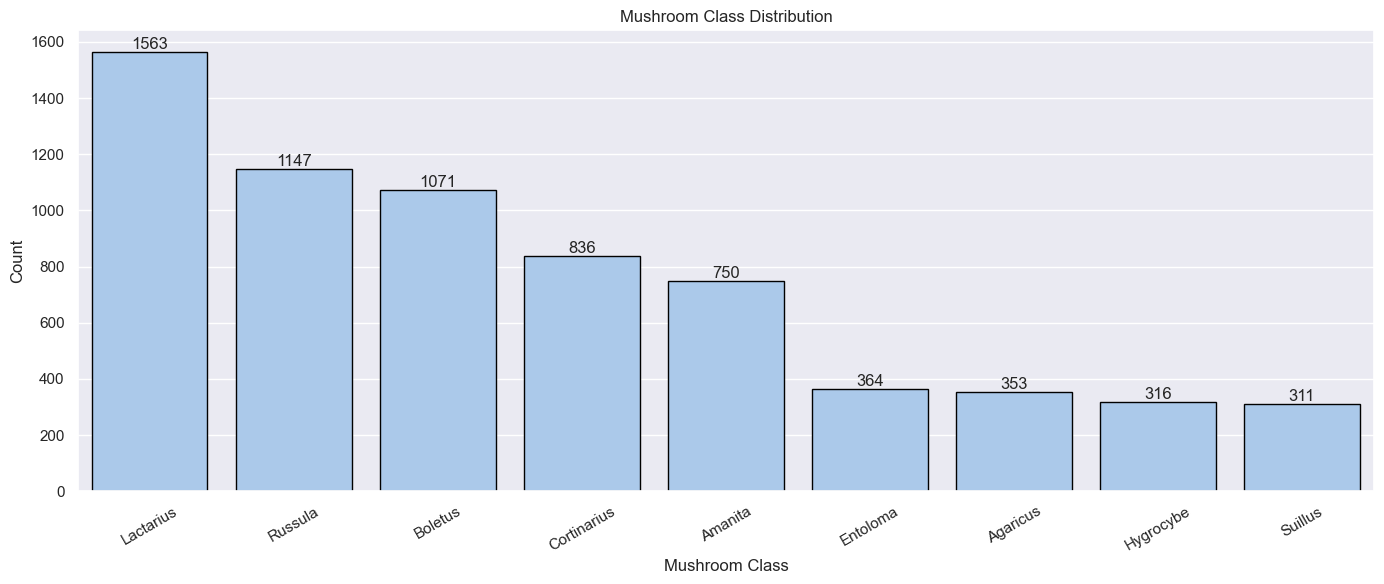

,count,mean,std,min,25%,50%,75%,max
Count,9.0,745.666667,449.517519,311.0,353.0,750.0,1071.0,1563.0


In [12]:
class_distribution_barplot(
    class_distribution_df, 
    x="Class", 
    y="Count", 
    title="Mushroom")

class_distribution_df.describe().T

Our mushroom dataset is not very balance, we have 9 different mushroom groups, some of the groups have way more images than other, for this we will use image augmentation to create additional images for all groups.

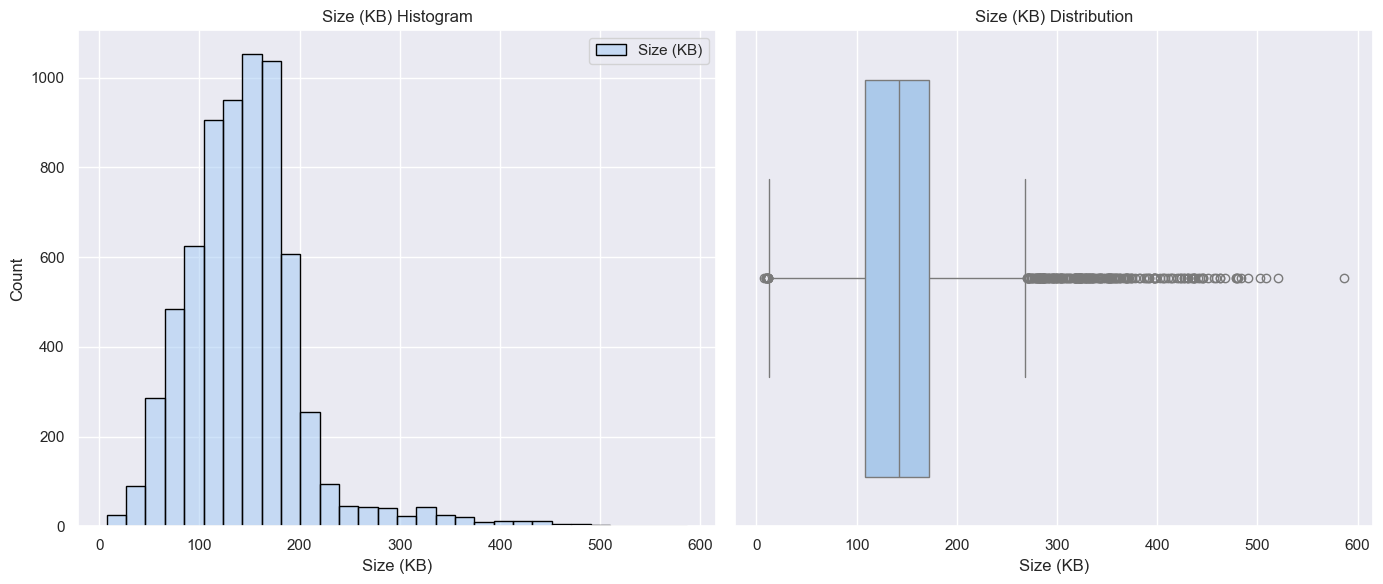

,count,mean,std,min,25%,50%,75%,max
Size (KB),6711.0,144.662668,58.919662,7.492188,108.407227,142.416992,172.675781,586.873047


In [13]:
horizontal_hist_box_plot(df=image_sizes_df, x="Size (KB)")

image_sizes_df.describe().T

Most of the images takes from 50KB to 200KB, while we have some of the outliers where image size is quite big, more than 300 KB. But this will not affect our model or analysis, those images with bigger memory are with higher resolution, and we will change resolution for all images to have one size for all.

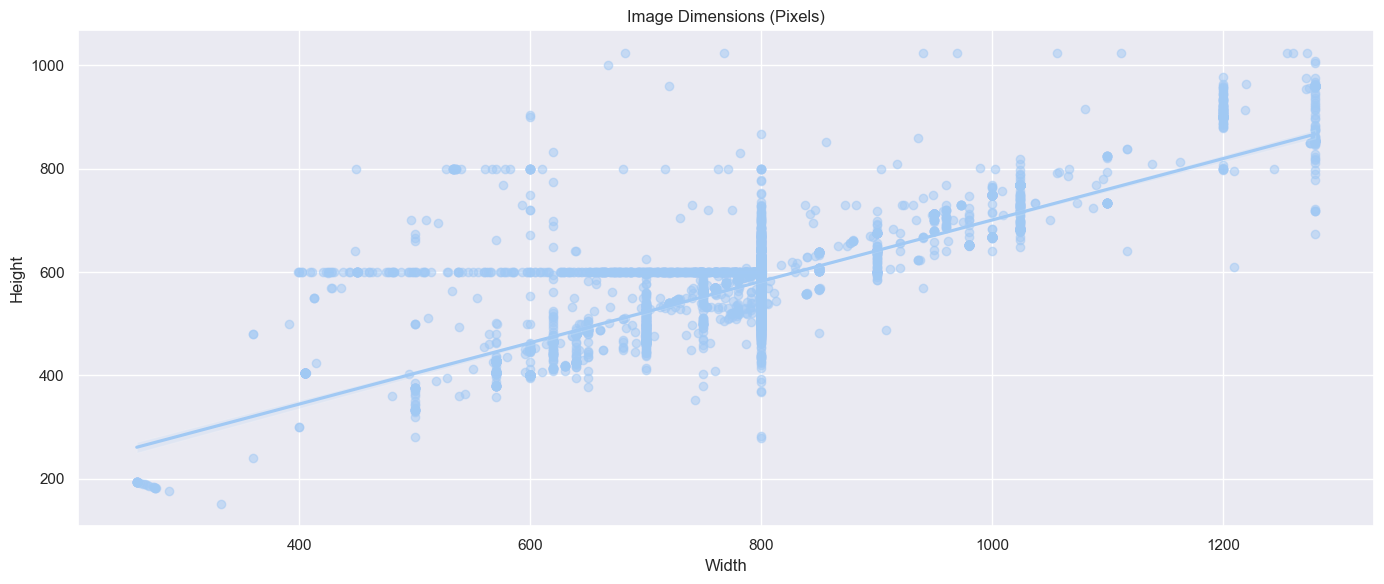

,count,mean,std,min,25%,50%,75%,max
width,6711.0,796.175086,132.832783,259.0,800.0,800.0,800.0,1280.0
height,6711.0,579.813292,100.138169,152.0,533.0,580.0,600.0,1024.0


In [14]:
plot_regplot(
    x=image_widths, y=image_heights, 
    title="Image Dimensions (Pixels)", 
    xlabel="Width", ylabel="Height")

pd.DataFrame(
    image_dimensions,
    columns=("width", "height")).describe().T

Overall we have 6711 images.

From image dimension, we can see that most of the images are taken in horizontally. While we have quite big range of dimension, most of the images are 800x580 size. 

Dataset consists of quite small images with width of 259 and height of 152, but we will not remove them as resize function will stretch image to our default size, if model perform bad we will consider removing those images.

## Data Engineering

To prevent overfitting, we will create additional image using different augmentation styles like rotating, flipping adjusting brightness.

We will split our data Train 70%, Validation 15% and Test 15% sets.

In [15]:
# Paths for processed data
processed_data_path = "data/Processed_Mushrooms"
train_path = os.path.join(processed_data_path, "train")
val_path = os.path.join(processed_data_path, "val")
test_path = os.path.join(processed_data_path, "test")

# Setting additional parameters
target_image_size = 224 # Mostly use in NN models

In [16]:
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

In [17]:
%%time
# Split dataset to train, validation ant test sets
split_data(
    data_path, 
    processed_data_path, 
    train_ratio=0.7, 
    val_ratio=0.15, 
    stratify=True)

Splitting dataset into train, validation, and test...
Processing class 'Agaricus' with 353 images.
  Class 'Agaricus' split as follows:
    Train: 247
    Validation: 53
    Test: 53
Processing class 'Amanita' with 750 images.
  Class 'Amanita' split as follows:
    Train: 524
    Validation: 113
    Test: 113
Processing class 'Boletus' with 1071 images.
  Class 'Boletus' split as follows:
    Train: 749
    Validation: 161
    Test: 161
Processing class 'Cortinarius' with 836 images.
  Class 'Cortinarius' split as follows:
    Train: 585
    Validation: 125
    Test: 126
Processing class 'Entoloma' with 364 images.
  Class 'Entoloma' split as follows:
    Train: 254
    Validation: 55
    Test: 55
Processing class 'Hygrocybe' with 316 images.
  Class 'Hygrocybe' split as follows:
    Train: 221
    Validation: 47
    Test: 48
Processing class 'Lactarius' with 1563 images.
  Class 'Lactarius' split as follows:
    Train: 1094
    Validation: 234
    Test: 235
Processing class 'Russula'

In [18]:
%%time
# Apply augmentation to the images
preprocess_images(
    train_path, 
    train_path, 
    target_size=(target_image_size, target_image_size), 
    augment=True # Will create additional images
)

Processing images...
Processing complete.
CPU times: total: 1min 11s
Wall time: 1min 12s


In [19]:
# Summary of splits
print("\nTrain Set Distribution:", count_files_in_split(train_path))
print("\nValidation Set Distribution:", count_files_in_split(val_path))
print("\nTest Set Distribution:", count_files_in_split(test_path))


Train Set Distribution: {'Agaricus': 1235, 'Amanita': 2618, 'Boletus': 3744, 'Cortinarius': 2917, 'Entoloma': 1267, 'Hygrocybe': 1105, 'Lactarius': 5470, 'Russula': 4009, 'Suillus': 1082}

Validation Set Distribution: {'Agaricus': 53, 'Amanita': 113, 'Boletus': 161, 'Cortinarius': 125, 'Entoloma': 55, 'Hygrocybe': 47, 'Lactarius': 234, 'Russula': 172, 'Suillus': 47}

Test Set Distribution: {'Agaricus': 53, 'Amanita': 113, 'Boletus': 161, 'Cortinarius': 126, 'Entoloma': 55, 'Hygrocybe': 48, 'Lactarius': 235, 'Russula': 173, 'Suillus': 47}


## Neural Network Model Creation

We get information from Data Analysis, and we prepare images from Data Engineering part, now we will create NN model which will help us identify mushroom classes. We will use already existing model ResNet18, which will be already pre-trained.

In [20]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-3
num_classes = len(os.listdir(train_path))

Because we are using ResNet18 model we will also need to scale pixel values using Normalize function to match model.

### Image Transformation

As we already perform some of the data augmentation in Data Engineering part, we will comment some of the functions, which can be uncommented if no augmentation was done before. <b>(Test runs show that previously augmented images works better for model)</b></b> We will implement additional augmentation by rotating image and adjusting not only brightness but also contrast and saturation..

In [21]:
# Define how images will be preprocessed
train_transform = transforms.Compose([
    transforms.Resize((target_image_size, target_image_size)),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],  # From ImageNet dataset mean 
        [0.229, 0.224, 0.225]), # From ImageNet dataset std
])

val_transform = transforms.Compose([
    transforms.Resize((target_image_size, target_image_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225]),
])

### Data Loading

Already predefine functions from torch will help use, we will use ImageFolder and DataLoader.

In [22]:
train_dataset = ImageFolder(root=train_path, transform=train_transform)
val_dataset = ImageFolder(root=val_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Model

In [23]:
# Define early stopping based on validation loss
early_stopping = EarlyStopping(
    monitor="val_loss",  # Metric to monitor
    patience=7,          # Number of epochs to wait for improvement
    verbose=True,        # Logs the status of early stopping
    mode="min"           # Stop when the loss is minimized
)

# Save the best model
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",   # Monitor by validation loss
    save_top_k=-1,       # Save  all checkpoints
    mode="min",           # Save the model with the lowest validation loss
    dirpath=checkpoints_dir,  
    filename="best_model_checkpoint_{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}"
)

In [24]:
if os.path.exists(checkpoints_dir):
    ckpt_files = glob.glob(os.path.join(checkpoints_dir, "*.ckpt"))
    for file in ckpt_files:
        os.remove(file)
        print(f"Deleted: {file}")
    if not ckpt_files:
        print("No .ckpt files found to delete.")
else:
    os.makedirs(checkpoints_dir)  # Create the directory if it doesn't exist
    print(f"Created checkpoint directory: '{checkpoints_dir}'")

Deleted: ./models/checkpoints\best_model_checkpoint_epoch=00_val_loss=0.5114_val_acc=0.8312.ckpt
Deleted: ./models/checkpoints\best_model_checkpoint_epoch=01_val_loss=0.5277_val_acc=0.8540.ckpt
Deleted: ./models/checkpoints\best_model_checkpoint_epoch=02_val_loss=0.4590_val_acc=0.8620.ckpt
Deleted: ./models/checkpoints\best_model_checkpoint_epoch=03_val_loss=0.4705_val_acc=0.8610.ckpt
Deleted: ./models/checkpoints\best_model_checkpoint_epoch=04_val_loss=0.6365_val_acc=0.8391.ckpt
Deleted: ./models/checkpoints\best_model_checkpoint_epoch=05_val_loss=0.5023_val_acc=0.8828.ckpt
Deleted: ./models/checkpoints\best_model_checkpoint_epoch=06_val_loss=0.5704_val_acc=0.8709.ckpt
Deleted: ./models/checkpoints\best_model_checkpoint_epoch=07_val_loss=0.6002_val_acc=0.8798.ckpt
Deleted: ./models/checkpoints\best_model_checkpoint_epoch=08_val_loss=0.6162_val_acc=0.8838.ckpt
Deleted: ./models/checkpoints\best_model_checkpoint_epoch=09_val_loss=0.6407_val_acc=0.8699.ckpt


In [25]:
class MushroomClassifier(pl.LightningModule):
    def __init__(self, num_classes, freeze_backbone=True):
        super(MushroomClassifier, self).__init__()
        self.save_hyperparameters()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.epoch_loss_history = {"train_loss": [], "val_loss": []}  # To store epoch-wise loss

        if freeze_backbone:
            self.freeze_backbone()

    def freeze_backbone(self):
        """Freeze the pre-trained backbone."""
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True  # Keep the head trainable

    def unfreeze_backbone(self):
        """Unfreeze the backbone for fine-tuning."""
        for param in self.model.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        """Save epoch-level train loss to epoch_loss_history."""
        train_loss = self.trainer.callback_metrics.get("train_loss", None)
        if train_loss is not None:
            self.epoch_loss_history["train_loss"].append(train_loss.item())

    def on_validation_epoch_end(self):
        """Save epoch-level validation loss to epoch_loss_history."""
        val_loss = self.trainer.callback_metrics.get("val_loss", None)
        if val_loss is not None:
            self.epoch_loss_history["val_loss"].append(val_loss.item())

    def configure_optimizers(self):
        backbone_params = [
            p for name, p in self.model.named_parameters() if not name.startswith("fc.")]
        head_params = self.model.fc.parameters()

        optimizer = torch.optim.Adam([
            {"params": head_params, "lr": learning_rate},
            {"params": backbone_params, "lr": learning_rate / 10}
        ])
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=5, gamma=0.5
        )
        return [optimizer], [scheduler]

In [26]:
model = MushroomClassifier(num_classes=num_classes)

#### Train the classification head

In [27]:
%%time
model = MushroomClassifier(
    num_classes=num_classes, 
    freeze_backbone=True)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator=DEVICE.type,
    log_every_n_steps=1
)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.4 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
267 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.775    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████████████████████████████████████████████████| 733/733 [01:14<00:00,  9.87it/s, v_num=4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.27it/s]
Epoch 1: 100%|█| 733/733 [01:12<00:00, 10.15it/s, v_num=4, val_loss=1.050, val_acc=0.623, train_loss=1.450, train_acc=0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.29it/s]
Epoch 2: 100%|█| 733/733 [01:17<00:00,  9.43it/s, v_num=4, val_loss=0.982, val_acc=0.652, train_loss=1.250, train_acc=0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█| 733/733 [01:17<00:00,  9.41it/s, v_num=4, val_loss=0.920, val_acc=0.675, train_loss=1.140, train_acc=0
CPU times: total: 39min 11s
Wall time: 6min 42s


In [28]:
print(trainer.logged_metrics)

{'val_loss': tensor(0.9197), 'val_acc': tensor(0.6753), 'train_loss': tensor(1.1399), 'train_acc': tensor(0.5925)}


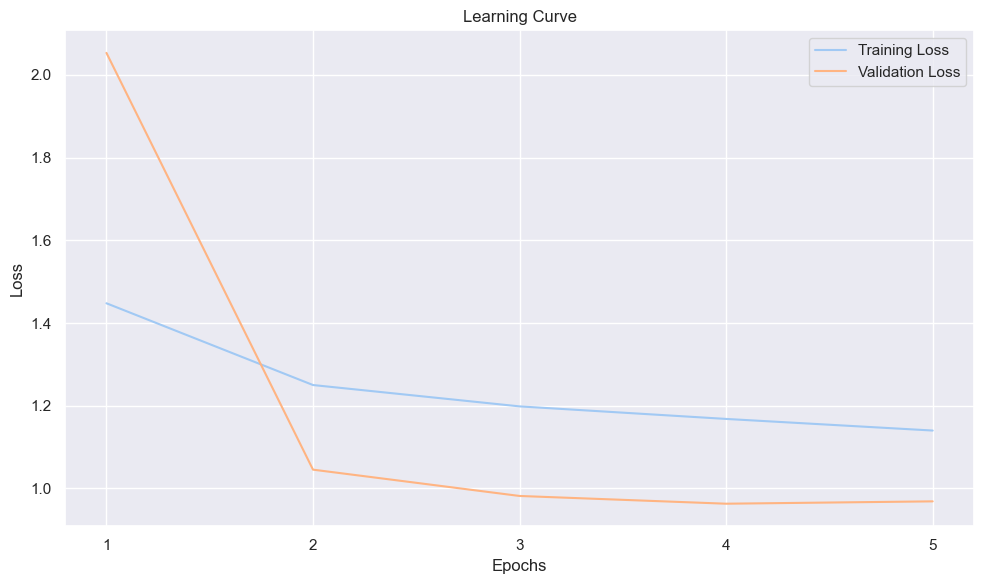

In [29]:
# Plot the learning curve
plot_learning_curve(model.epoch_loss_history)

#### Fine Tune entire model

In [30]:
# Reset epochs_loss_history to get new ones seperatly
model.epoch_loss_history = {"train_loss": [], "val_loss": []}

In [31]:
%%time
model.unfreeze_backbone()  # Unfreeze the backbone

fine_tune_trainer = pl.Trainer(
    max_epochs=20,  # Train for more epochs
    callbacks=[checkpoint_callback, early_stopping],
    accelerator=DEVICE.type,
    log_every_n_steps=1,
    logger=True
)
fine_tune_trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.4 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.775    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████████████████████████████████████████████████| 733/733 [01:17<00:00,  9.48it/s, v_num=5]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.20it/s]
Epoch 0: 100%|█| 733/733 [01:21<00:00,  8.95it/s, v_num=5, val_loss=0.627, val_acc=0.807, train_loss=0.881, train_acc=0

Metric val_loss improved. New best score: 0.627


Epoch 1: 100%|█| 733/733 [01:18<00:00,  9.36it/s, v_num=5, val_loss=0.627, val_acc=0.807, train_loss=0.881, train_acc=0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.15it/s]
Epoch 1: 100%|█| 733/733 [01:23<00:00,  8.82it/s, v_num=5, val_loss=0.604, val_acc=0.814, train_loss=0.593, train_acc=0

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.604


Epoch 2: 100%|█| 733/733 [01:17<00:00,  9.45it/s, v_num=5, val_loss=0.604, val_acc=0.814, train_loss=0.593, train_acc=0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.16it/s]
Epoch 2: 100%|█| 733/733 [01:22<00:00,  8.92it/s, v_num=5, val_loss=0.554, val_acc=0.843, train_loss=0.470, train_acc=0

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.554


Epoch 3: 100%|█| 733/733 [01:17<00:00,  9.45it/s, v_num=5, val_loss=0.554, val_acc=0.843, train_loss=0.470, train_acc=0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]
Epoch 3: 100%|█| 733/733 [01:22<00:00,  8.90it/s, v_num=5, val_loss=0.545, val_acc=0.858, train_loss=0.393, train_acc=0

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.545


Epoch 4: 100%|█| 733/733 [01:18<00:00,  9.39it/s, v_num=5, val_loss=0.545, val_acc=0.858, train_loss=0.393, train_acc=0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.18it/s]
Epoch 5: 100%|█| 733/733 [01:23<00:00,  8.77it/s, v_num=5, val_loss=0.560, val_acc=0.851, train_loss=0.335, train_acc=0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.03it/s]
Epoch 5: 100%|█| 733/733 [01:28<00:00,  8.29it/s, v_num=5, val_loss=0.500, val_acc=0.888, train_loss=0.202, train_acc=0

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.500


Epoch 6: 100%|█| 733/733 [01:25<00:00,  8.53it/s, v_num=5, val_loss=0.500, val_acc=0.888, train_loss=0.202, train_acc=0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.72it/s]
Epoch 6: 100%|█| 733/733 [01:30<00:00,  8.06it/s, v_num=5, val_loss=0.495, val_acc=0.893, train_loss=0.166, train_acc=0

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.495


Epoch 7: 100%|█| 733/733 [01:20<00:00,  9.05it/s, v_num=5, val_loss=0.495, val_acc=0.893, train_loss=0.166, train_acc=0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.94it/s]
Epoch 8: 100%|█| 733/733 [01:21<00:00,  8.96it/s, v_num=5, val_loss=0.547, val_acc=0.878, train_loss=0.151, train_acc=0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.04it/s]
Epoch 9: 100%|█| 733/733 [01:23<00:00,  8.74it/s, v_num=5, val_loss=0.526, val_acc=0.892, train_loss=0.136, train_acc=0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.495. Signaling Trainer to stop.


Epoch 13: 100%|█| 733/733 [01:26<00:00,  8.48it/s, v_num=5, val_loss=0.642, val_acc=0.901, train_loss=0.051, train_acc=
CPU times: total: 1h 57min 17s
Wall time: 20min 7s


In [32]:
print(fine_tune_trainer.logged_metrics)

{'val_loss': tensor(0.6420), 'val_acc': tensor(0.9007), 'train_loss': tensor(0.0510), 'train_acc': tensor(0.9835)}


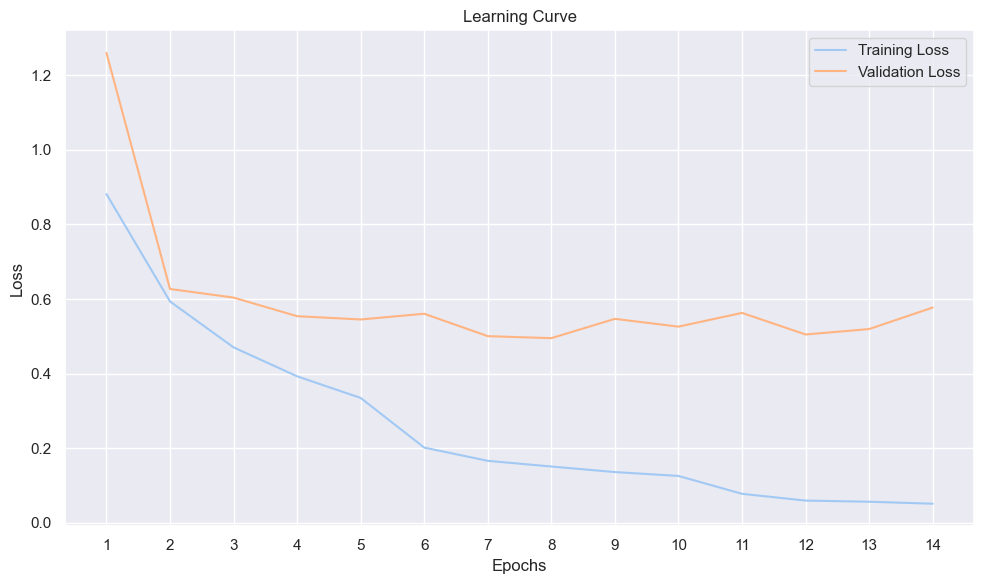

In [33]:
plot_learning_curve(model.epoch_loss_history)

### Evaluate Model

For evaluation, we will use test dataset and best model from checkpoint.

In [34]:
print("Best checkpoint:", checkpoint_callback.best_model_path)

Best checkpoint: E:\GitHub\rposkr-DL.1.5\models\checkpoints\best_model_checkpoint_epoch=06_val_loss=0.4950_val_acc=0.8928.ckpt


In [35]:
# Load the test set
test_dataset = ImageFolder(
    root=test_path, 
    transform=val_transform)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False)

# Get class names
class_names = test_dataset.classes

In [36]:
# Load checkpoint model
checkpoint_model = MushroomClassifier.load_from_checkpoint(
    checkpoint_callback.best_model_path, 
    num_classes=num_classes)

checkpoint_model.eval()

MushroomClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [37]:
# Evaluate the model
labels, preds = evaluate_model(checkpoint_model, test_loader, class_names, device=DEVICE)

Classification Report:
              precision    recall  f1-score   support

    Agaricus       0.79      0.77      0.78        53
     Amanita       0.93      0.84      0.88       113
     Boletus       0.94      0.95      0.95       161
 Cortinarius       0.87      0.82      0.84       126
    Entoloma       0.79      0.89      0.84        55
   Hygrocybe       0.98      0.88      0.92        48
   Lactarius       0.85      0.89      0.87       235
     Russula       0.85      0.90      0.87       173
     Suillus       0.82      0.70      0.76        47

    accuracy                           0.87      1011
   macro avg       0.87      0.85      0.86      1011
weighted avg       0.87      0.87      0.87      1011



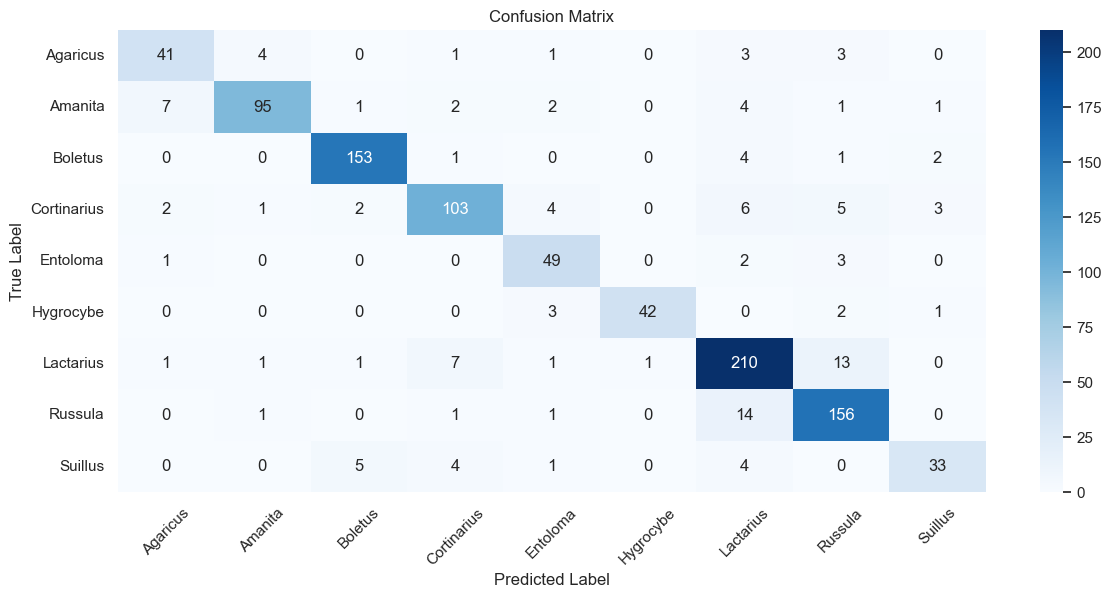

In [38]:
fig, ax = plt.subplots() 

cm_matrix(
    labels=labels, 
    preds=preds, 
    class_names=class_names, 
    model_name="Confusion Matrix", 
    ax=ax, 
    xticks_rotation=45)

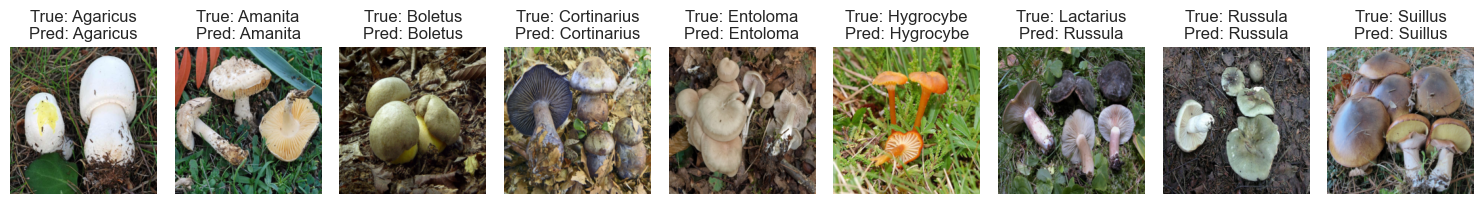

In [39]:
# Visualize some predictions
visualize_predictions(checkpoint_model, test_loader, class_names, num_images=9)

In [40]:
# Evaluate last model not from the checkpoint
labels, preds = evaluate_model(model, test_loader, class_names, device=DEVICE)

Classification Report:
              precision    recall  f1-score   support

    Agaricus       0.80      0.75      0.78        53
     Amanita       0.89      0.84      0.86       113
     Boletus       0.93      0.97      0.95       161
 Cortinarius       0.90      0.84      0.87       126
    Entoloma       0.91      0.76      0.83        55
   Hygrocybe       0.98      0.88      0.92        48
   Lactarius       0.85      0.93      0.89       235
     Russula       0.91      0.91      0.91       173
     Suillus       0.77      0.79      0.78        47

    accuracy                           0.88      1011
   macro avg       0.88      0.85      0.87      1011
weighted avg       0.89      0.88      0.88      1011



### Export Model

Model will be saved with all weights and model class, so after loading no need to redefine the model class.

In [41]:
# Save the entire model
torch.save(checkpoint_model, f"{model_path}/mushroom_classifier_full.pth")

## Summary

We found some images which are not usable for NN model and analysis, they totally white or corrupted and part of image not loaded. Those images move to folder bad and will not be used.

Mushroom dataset consists of 9 different classes, dataset is imbalance. 

Most of the images takes from 50KB to 200KB. 

We worked with of 6711 images, as number is quite low we use image augmentation - 
Rotation, flipping, brightness adjustment to create additional images.

Most of the images are 800x580 size.

We created a Neural Network model using backbone of ResNet18 model.
<ul>
    <li>Use CUDA for faster learning</li>
    <li>Fine Tune model</li>
    <li>Set different learning rate for head of model and backbone</li>
    <li>For head used smaller epoch count, increase it while unfreezing the 
backbone of the model -> best-model-checkpoint_*.ckpt</li>
    <li>Saved the best model with the lowest validation loss</li>
    <li>Model evaluated</li>
    <li>Accuracy score with unseen data with best model: 87%</li>
</ul>

## Suggestion For Improvement

<ul>
    <li>Try ensemble methods that combine the strengths of different models.</li>
    <li>Try different image augmentation methods.</li>
    <li>Build custom Neural Network model from the scratch.</li>
</ul>